# Week 2 - Connect Tiki Scraper to PostgreSQL database

## Update the Scraper

In [1]:
# Import libraries
import pandas as pd
import requests
import re
import psycopg2
from bs4 import BeautifulSoup

In [2]:
# Parser function to retrieve and parse the HTML code of a website 
def parser(url):
    
    # Plain HTML code
    plain = requests.get(url).text
    
    # Parser
    s = BeautifulSoup(plain, "html.parser")
    
    return s

In [3]:
# Function to get all URLs of categories on Tiki
def get_urls():
    
    url = 'https://tiki.vn/'
          
    # Run Parser on Tiki
    s = parser(url)
    
    # Initialize an empty list of category 
    category_list = []

    # Scrape through the navigator bar on Tiki homepage
    for i in s.findAll('a',{'class':'MenuItem__MenuLink-tii3xq-1 efuIbv'}):
        
        # Get the category value
        category = i.find('span',{'class':'text'}).text 
        
        # Get the url value
        url = i['href'] + "&page=1"
        
        # Add category and url values to list
        category_list.append((category, url))
        
    return category_list

## Connect to PostgreSQL Database

In [4]:
# Function to create connection to our PostgreSQL database
def get_connection():
    connection = psycopg2.connect(user = "reichu2",
                                  password = 'phuongchu',
                                  host = "127.0.0.1",
                                  port = "5432",
                                  database = "tiki")
    return connection

## Create new table in PostgreSQL Database¶

In [5]:
# Function to create an empty `products` table in our database if it doesn't exist yet
def create_products_table():
    
    print('INFO create_products_table(): Create table products')
    
    try:
        # Create connection & cursor
        connection = get_connection()
        cursor = connection.cursor() 
        
        # Execute the query #chú ý đoạn ID
        cursor.execute("""
        CREATE TABLE IF NOT EXISTS products(
            product_id INTEGER, 
            product_seller_id VARCHAR(20),
            title TEXT,
            price INTEGER,
            brand TEXT,
            img_url TEXT,
            rating TEXT,
            comments INTEGER,
            category TEXT,
            tikinow BOOLEAN
        );""")
        
        # Commit the changes made to our database
        connection.commit()

    except (Exception, psycopg2.Error) as error :
        print ("ERROR create_products_table(): Error while connecting to PostgreSQL", error)
        
        # In case of error, cancel all changes made to our database during the connection
        connection.rollback()
        return
    
    finally:
    
        # Close the connection & cursor
        cursor.close()
        connection.close()

In [6]:
create_products_table()

INFO create_products_table(): Create table products


## Insert data to PostSQL Database

In [7]:
# Function to insert new data to our table
def insert_data_to_db(data, table_name):
    
    print('INFO insert_data_to_db(): Insert data to DB')
    
    try:
        # Create connection & cursor 
        connection = get_connection()
        cursor = connection.cursor()
        
        # For each row (product) in data (product page),...
        for row in data:
            # Create the query to insert product information to 'table_name'
            query = "INSERT INTO products VALUES (%s, %s, %s, %s ,%s, %s, %s, %s, %s, %s)"
            
            # Execute the query
            cursor.execute(query, row)
            
            # Commit the changes made to our database
            connection.commit()

    except (Exception, psycopg2.Error) as error :
        print ("ERROR save_data_to_db(): Error while connecting to PostgreSQL", error)
        
        # In case of error, cancel all changes made to our database during the connection
        connection.rollback()
        
    finally:
        
        # Close the connection & cursor
        cursor.close()
        connection.close()

In [8]:
# Function to get all data from table 'products'
def select_data_from_db():
    
    try:
        # Create connection & cursor 
        connection = get_connection()
        cursor = connection.cursor()
        
        # Get all data from table 'products'
        cursor.execute("SELECT * FROM products")      
        
        # Fetch (Collect) the data and save them in 'data'
        data = cursor.fetchall()
        
        return data

    except (Exception, psycopg2.Error) as error :
        print ("ERROR save_data_to_db(): Error while connecting to PostgreSQL", error)
        
        # In case of error, cancel all changes made to our database during the connection
        connection.rollback()
        
    finally:
        
        # Close the connection & cursor
        cursor.close()
        connection.close()

In [9]:
# Web scrape function
def scrape(cat, url):
    
    # Initialize empty 'results' list
    results = []
   
    # Run Parser on the product page
    s = parser(url)
    
    # Find all tags <div class='product-item'> and store them in 'prodct_items' list, each tag represent a product
    product_items = s.findAll('div',{'class':'product-item'})

    # If the tag list is empty (i.e. the page doesn't have any product), return an empty list.
    if len(product_items) == 0:
        return []

    # If the tag list is not empty (i.e. the page has products),...
    else: 
        
        # Iterate through all product and store the product information in the 'row' list
        for i in range(len(product_items)):
            
            # find tikinow
            tikinow = product_items[i].find_all('i',{'class':'tikicon'})
            
            # find rating of each product
            rating = product_items[i].select("span.rating-content span[style]")
            if rating != []:
                rating = rating[0]["style"][len("width:"):]
            else:
                rating = ''
            
            
            # find total number of comments about each product
            find_comments = product_items[i].find('p', {'class':'review'})

            # if there is no review => skip, if there is parse the number
            is_there_comments = product_items[i].select("[class=review]")

            # get content between review tag
            if is_there_comments != []:
                for comment in find_comments:
                    for x in re.findall('\d+', comment):
                        int(x)
                    total_num_of_comments = x
            else:
                total_num_of_comments = 0
            
            
            # get the link of each product
#             link_product = product_items[i].find('a',{'class':''})['href']
#             s_product = parser(link_product)
            
#             user = s_product.select_one("#review-lazy .review-list > .item .product-col-1 p.name"
            
            
            row = [product_items[i]['data-id'], 
                   product_items[i]['data-seller-product-id'], 
                   product_items[i]['data-title'],
                   product_items[i]['data-price'], 
                   product_items[i]['data-brand'],
                   product_items[i].find('img',{'class':'product-image img-responsive'})['src'],
                   rating,
                   total_num_of_comments,
                   cat,
                   '1' if tikinow else '0']   

            # Add the product information of each product into 'results' list
            results.append(row)
            
    # Return the list `results`   
    return results

In [10]:
# Run scrape fuction on every page

def scrape_all():
    print('INFO scrape_all(): Start scraping')

    # Initialize 'queue' list with the results of get_urls()
    queue = get_urls()

    # Create table `products` if it doesn't exist yet
    # 
    # results = []  <-- This is what we did in the first week
    create_products_table()

    # While there are items in `queue`,...
    while len(queue) != 0:

        # `url` is set to the url of last item in `queue`
        url = queue[-1][-1]

        # `cat` is set to the category of last item in `queue`
        cat = queue[-1][0]

        # Remove the last item in queue
        queue = queue[:-1]

        print('Scraping', cat)

        # Run scrape(cat, url) with given `cat` and `url`
        new_rows = scrape(cat, url)

        # If the result of scrape(cat, url) is not an empty list (i.e. the page has products),...  
        if len(new_rows) != 0:

            # Insert the result of scrape(cat, url) to table `product`
            # results += new_rows  <-- This is what we did in the first week
            insert_data_to_db(new_rows, "products")

            # Generate next page url 
            page = int(url[url.rfind("=")+1:])+1
            url = url[:url.rfind("=")+1] + str(page)

        # Use this to limit our scraper to scrape only the first 10 pages of each category
        # We do this to test our scraper with a smaller task first before running through every product page
        
        #if page < 1:

            # Add the new page url to the end of list `queue`
            queue.append((cat,url))

        print('Add next page', page)
    
    # Return the list `results`
    return 

## Getting all data in table products and put them in a pandas dataframe

In [ ]:
scrape_all()

In [116]:
data = select_data_from_db()
df = pd.DataFrame(data, columns = ['product_id', 'seller_id', 'title', 'price', 'brand', 'image_url', 'rating', 'comments', 'category','tikinow'])
df.sample(5)

,product_id,seller_id,title,price,brand,image_url,rating,comments,category,tikinow
19001,21062694,21062695,Giá Đỡ Điện Thoại Nam Châm Trên Xe Ô Tô Đen,172000,OEM,https://salt.tikicdn.com/cache/200x200/ts/prod...,,0,Hàng quốc tế,False
1170,2385721,3240191,Dịch Vụ Thay Loa Ngoài iPhone 6s,360000,,https://salt.tikicdn.com/cache/200x200/ts/prod...,,0,Voucher - Dịch Vụ - Thẻ Cào,False
22043,22503707,22503708,iPega PG-9129 Wireless Gamepad Multimedia Game...,562000,Ipega,https://salt.tikicdn.com/cache/200x200/ts/prod...,,0,Hàng quốc tế,False
46472,7337643,7337645,Balo Da Nữ AZDBN180TI (không móc khóa),199000,OEM,https://salt.tikicdn.com/cache/200x296/ts/prod...,,0,Thời trang - Phụ kiện,False
11899,1036538,1037172,Cuốn Sách Lớn Đầu Tiên Của Tớ: Chim,84000,Catherine D. Hughes,https://salt.tikicdn.com/cache/200x200/media/c...,,0,"Sách, VPP & Quà Tặng",True


## Data analysis

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [117]:
# remove all '%' character from rating column and change column from object type to integer
df['rating'] = df['rating'].map(lambda x: x.rstrip('%'))

# try:
#     df['rating'] = df['rating'].astype(str).astype(int)
# except ValueError:
#     pass  

df.sample(5)

,product_id,seller_id,title,price,brand,image_url,rating,comments,category,tikinow
127449,20524151,20524152,Chuột chơi game Logitech G Pro Hero 16K - Hàng...,1679000,Logitech,https://salt.tikicdn.com/cache/200x200/ts/prod...,,0,Phụ Kiện - Thiết Bị Số,True
73029,20624156,20624157,Bảng đinh uống bia may mắn (DRINKO SHOT GAME),459000,OEM,https://salt.tikicdn.com/cache/200x200/ts/prod...,,0,"Đồ chơi, Mẹ & Bé",False
1581,15416546,15416547,Gói Khám Toàn Diện Cho Trẻ Em Từ 5 - 9 Tuổi Tạ...,1844500,,https://salt.tikicdn.com/cache/200x200/ts/prod...,,0,Voucher - Dịch Vụ - Thẻ Cào,False
74507,12194180,12194182,Bộ Đồ Bé Trai Họa Tiết Unifriend UNI0226 - Trắng,250000,Unifriend,https://salt.tikicdn.com/cache/200x200/ts/prod...,,0,"Đồ chơi, Mẹ & Bé",False
86323,1325531,4072409,Combo 10 Cặp Nút Tai Chống Ồn 3M 1100 - Cam,40000,3M,https://salt.tikicdn.com/cache/200x200/ts/prod...,80,5,Nhà Cửa Đời Sống,True


## **General info and overview of the dataset**

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141006 entries, 0 to 141005
Data columns (total 10 columns):
product_id    141006 non-null int64
seller_id     141006 non-null object
title         141006 non-null object
price         141006 non-null int64
brand         141006 non-null object
image_url     141006 non-null object
rating        141006 non-null object
comments      141006 non-null int64
category      141006 non-null object
tikinow       141006 non-null bool
dtypes: bool(1), int64(3), object(6)
memory usage: 9.8+ MB


In [50]:
print ("There are", len(df), "scraped products on Tiki, belong to", df['category'].nunique(),"categories.")
print ("However, the real number of products is", df['product_id'].nunique(), "products.")
print ("Therefore, there are",len(df)-df['product_id'].nunique(),"duplicated products.")
print ("There are", df['seller_id'].nunique() ,"different sellers on Tiki.")
print ("Tiki's products belong to", len(df.groupby(df['brand'].str.lower())) , "different brands.") #avoid case sensitive

There are 141006 scraped products on Tiki, belong to 16 categories.
However, the real number of products is 121169 products.
Therefore, there are 19837 duplicated products.
There are 121160 different sellers on Tiki.
Tiki's products belong to 12265 different brands.


In [68]:
df.describe()

,product_id,price,comments
count,1.410060e+05,1.410060e+05,141006.000000
mean,9.558885e+06,2.068569e+06,3.309412
std,6.989837e+06,1.123901e+07,24.774720
min,5.084400e+04,0.000000e+00,0.000000
25%,2.833796e+06,9.900000e+04,0.000000
50%,9.140658e+06,2.200000e+05,0.000000
75%,1.496588e+07,7.190000e+05,1.000000
max,2.443081e+07,6.003250e+08,3436.000000


## Top 10 brands with the most products are:

|Brands|Number of products|
|:---:|:---:|
|OEM (original equipment manufacturer)| 37885|
|Non-specified sellers | 5706|
|Joy collection    | 3588|
|hp                |  876|
|Hikvision          | 833|
|Panasonic          | 681|
|Samsung        |     661|
|Zippo          |     620|
|Xiaomi          |    560|
|Sunhouse         |   538|

In [59]:
df['brand'].str.lower().value_counts().head(10)

oem               37885
                   5706
joy collection     3588
hp                  876
hikvision           833
panasonic           681
samsung             661
zippo               620
xiaomi              560
sunhouse            538
Name: brand, dtype: int64

## The number of products in each category

In [65]:
df['category'].value_counts()

Hàng Tiêu Dùng - Thực Phẩm     9984
Làm Đẹp - Sức Khỏe             9984
Laptop - Thiết bị IT           9984
Nhà Cửa Đời Sống               9984
Đồ chơi, Mẹ & Bé               9984
Xe Máy, Ô tô, Xe Đạp           9984
Sách, VPP & Quà Tặng           9984
Thể Thao - Dã Ngoại            9984
Phụ Kiện - Thiết Bị Số         9984
Hàng quốc tế                   9984
Điện Gia Dụng                  9984
Thời trang - Phụ kiện          9953
Máy Ảnh - Quay Phim            9555
Điện Tử - Điện Lạnh            6023
Voucher - Dịch Vụ - Thẻ Cào    4689
Điện Thoại - Máy Tính Bảng      962
Name: category, dtype: int64

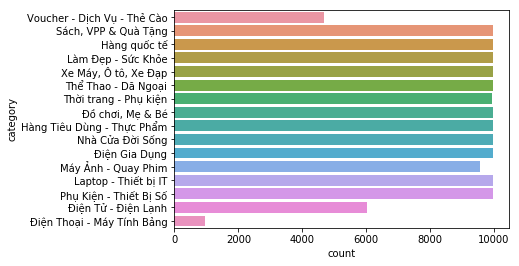

In [121]:
count_cat = sns.countplot(y='category', data=df)

## Price on Tiki

In [71]:
df[df['price'] == df['price'].min()]

,product_id,seller_id,title,price,brand,image_url,rating,comments,category,tikinow
111751,16831560,16831561,Camera HCD-E6070RP AHD Samsung Dạng Dome 2MP -...,0,Samsung,https://salt.tikicdn.com/cache/200x200/ts/prod...,,0,Máy Ảnh - Quay Phim,False


In [72]:
df[df['price'] == df['price'].max()]

,product_id,seller_id,title,price,brand,image_url,rating,comments,category,tikinow
29928,15085097,15085098,Xe Môtô Triumph Scrambler 1200 XE - Trắng Xanh,600325000,Triumph Motorcycle,https://salt.tikicdn.com/cache/200x200/ts/prod...,,0,"Xe Máy, Ô tô, Xe Đạp",True
29930,15085101,15085102,Xe Môtô Triumph Scrambler 1200 XE - COBALT BLU...,600325000,Triumph Motorcycle,https://salt.tikicdn.com/cache/200x200/ts/prod...,,0,"Xe Máy, Ô tô, Xe Đạp",True
30381,15085097,15085098,Xe Môtô Triumph Scrambler 1200 XE - Trắng Xanh,600325000,Triumph Motorcycle,https://salt.tikicdn.com/cache/200x200/ts/prod...,,0,"Xe Máy, Ô tô, Xe Đạp",True
30383,15085101,15085102,Xe Môtô Triumph Scrambler 1200 XE - COBALT BLU...,600325000,Triumph Motorcycle,https://salt.tikicdn.com/cache/200x200/ts/prod...,,0,"Xe Máy, Ô tô, Xe Đạp",True


In [77]:
print ("The mean price in Tiki is",round(df['price'].mean()),"VND")

The mean price is 2068569 VND


## Tiki Now and Comments

In [110]:
print("There are",len(df[df['tikinow'] == True]),"products with Tikinow and",len(df[df['tikinow'] == False]),"products without Tikinow.")

There are 46745 products with Tikinow and 94261 products without Tikinow.


In [111]:
df[df['comments'] == df['comments'].min()].head(2)

,product_id,seller_id,title,price,brand,image_url,rating,comments,category,tikinow
0,21534194,21534195,BA GÁC NƯỚNG & BIA - COMBO NƯỚNG BA GÁC ĐẶC BI...,320000,,https://salt.tikicdn.com/cache/200x200/ts/prod...,,0,Voucher - Dịch Vụ - Thẻ Cào,False
1,23264624,23264630,Capella Park View - Buffet Chay Mùa Vu Lan Hơn...,189000,,https://salt.tikicdn.com/cache/200x200/ts/prod...,,0,Voucher - Dịch Vụ - Thẻ Cào,False


In [120]:
df[df['comments'] == df['comments'].min()].head(3)

,product_id,seller_id,title,price,brand,image_url,rating,comments,category,tikinow
0,21534194,21534195,BA GÁC NƯỚNG & BIA - COMBO NƯỚNG BA GÁC ĐẶC BI...,320000,,https://salt.tikicdn.com/cache/200x200/ts/prod...,,0,Voucher - Dịch Vụ - Thẻ Cào,False
1,23264624,23264630,Capella Park View - Buffet Chay Mùa Vu Lan Hơn...,189000,,https://salt.tikicdn.com/cache/200x200/ts/prod...,,0,Voucher - Dịch Vụ - Thẻ Cào,False
2,16563156,16563157,Aka House - Đại Tiệc Buffet Nướng & Lẩu Nhật B...,229000,,https://salt.tikicdn.com/cache/200x200/ts/prod...,,0,Voucher - Dịch Vụ - Thẻ Cào,False


In [105]:
print("There are",len(df[df['comments'] == df['comments'].min()]),"products without any comments.")

There are 89686 products without any comments.


In [103]:
df[df['comments'] == df['comments'].max()]

,product_id,seller_id,title,price,brand,image_url,rating,comments,category,tikinow
4699,378448,77142,Nhà Giả Kim,44850,Paulo Coelho,https://salt.tikicdn.com/cache/200x200/media/c...,93,3436,"Sách, VPP & Quà Tặng",True
